In [498]:
import numpy as np
import pandas as pd
import json
import os
import pprint
import seaborn as sns
from krippendorff import alpha
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters, cohens_kappa, to_table
from irrCAC.raw import CAC
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

### Set up variables and load conversations

In [499]:
human_eval_csv = "qualtrics/results/pilot-eval-irr.csv"
autotod_mwoz_eval_json = "results/judge_results_mwoz_autotod/20250403_025805/mwoz-autotod-gpt-4o_j.json"
tau_air_eval_json = "results/judge-results-tau/20250131_152503-tau-4o-airline/tau-gpt-4o_j.json"
tau_retail_eval_json = "results/judge-results-tau/20250131_152422-tau-4o-retail/tau-gpt-4o_j.json"
dial_batch_json = "datasets/irr_eval_batch.json"
num_annotators = 10

# load dialogues
with open(autotod_mwoz_eval_json, 'r') as f:
		autotod_mwoz_eval = json.load(f)
autotod_mwoz_dials = autotod_mwoz_eval.get('dialogues', [])
with open(tau_air_eval_json, 'r') as f:
		tau_air_eval = json.load(f)
tau_air_dials = tau_air_eval['dialogues']
with open(tau_retail_eval_json, 'r') as f:
		tau_retail_eval = json.load(f)
tau_retail_dials = tau_retail_eval['dialogues']
# load batches
batch_list = None
with open(dial_batch_json, 'r') as f:
		batch_list = json.load(f)
if batch_list is None or len(batch_list) == 0:
		print('No batches found at this path:',  dial_batch_json)
		exit()
batch_order = batch_list["order"]
print("batch order:")
pprint.pprint(batch_order, compact=True)

batch order:
[{'id': 'pmul3301', 'type': 'autotod_mwoz'},
 {'id': 'pmul3283', 'type': 'autotod_mwoz'},
 {'id': 'mul2316', 'type': 'autotod_mwoz'}, {'id': '9', 'type': 'tau_retail'},
 {'id': '2', 'type': 'tau_airline'}]


### Order dialogues into batches

In [500]:
def get_batch_dialogues(
	mwoz_dialogues: dict, 
	tau_air_dialogues: dict, 
	tau_retail_dialogues: dict, 
	batch_list: dict
) -> dict:
	#load dialogues
	batch_dials = []
	mwoz_batch_ids = batch_list["autotod_mwoz"]
	tau_air_batch_ids = batch_list["tau"]["airline"]
	tau_retail_batch_ids = batch_list["tau"]["retail"]
	# load batch 
	for batch_id in mwoz_batch_ids:
		for id, dial in mwoz_dialogues.items():
			if id.split(".json")[0].lower() == batch_id:
				batch_dials.append(dial)
				break
	for batch_id in tau_air_batch_ids:
		for id, dial in tau_air_dialogues.items():
			if id == batch_id:
				batch_dials.append(dial)
				break
	for batch_id in tau_retail_batch_ids:
		for id, dial in tau_retail_dialogues.items():
			if id == batch_id:
				batch_dials.append(dial)
				break
	tot_batch_len = len(mwoz_batch_ids) + len(tau_air_batch_ids) + len(tau_retail_batch_ids)
	if len(batch_dials) != tot_batch_len:
		print("filtered dials size does not match batches:", len(batch_dials), tot_batch_len)
		exit()
	return batch_dials

batch_dialogues = get_batch_dialogues(
	autotod_mwoz_dials, 
	tau_air_dials, 
	tau_retail_dials, 
	batch_list
)
print("batch dialogues:") 
pprint.pprint(batch_dialogues, compact=True)

batch dialogues:
[[{'conversation_history': '',
   'db': [{'api_input': {'area': 'centre',
                         'internet': 'any',
                         'name': 'any',
                         'parking': 'any',
                         'pricerange': 'any',
                         'stars': '4',
                         'type': 'any'},
           'api_name': 'query_hotels',
           'api_result': {'result': [{'address': '56 saint barnabas road',
                                      'area': 'centre',
                                      'id': '2',
                                      'internet': 'yes',
                                      'location': [52.1986444444444,
                                                   0.138133333333333],
                                      'name': 'alexander bed and breakfast',
                                      'parking': 'yes',
                                      'phone': '01223525725',
                                      'postco

### Process Qualtrics Human Eval Scores From CSV

In [501]:
def process_extracted_human_csv_data(
	input_file: str, 
	batch_dialogues: list, 
	batch_order: dict
) -> dict:
	"""Read CSV data and convert to appropriate format"""
	eval_csv = pd.read_csv(input_file, on_bad_lines='warn') 
	start_col = 'QID100_1'
	end_col = 'QID130_3'
	search_str = '2025'
	turn_result = {}
	dial_result = {}
	first_eval_row = eval_csv.StartDate.str.contains(search_str).idxmax()
	human_scores = eval_csv.loc[first_eval_row:, start_col:end_col].to_numpy()
	mapping = {
		"Very Good": 5.0, 
		"Good": 4.0, 
		"Fair": 3.0, 
		"Bad": 2.0, 
		"Very Bad": 1.0
	}
	# mapping = {
	# 	"Very Good": 3.0, 
	# 	"Good": 3.0, 
	# 	"Fair": 2.0, 
	# 	"Bad": 1.0, 
	# 	"Very Bad": 1.0
	# }
	vectorized_map = np.vectorize(lambda x: mapping[x])
	int_scores = vectorized_map(human_scores)
	# extract scores into results dialogue map
	scores_idx = 0
	for i, dial in enumerate(batch_dialogues):
		dial_id = batch_order[i]["id"]
		turn_result[dial_id] = []
		# add turn scores
		for _ in dial:
			turn_result[dial_id].append({
				'conv_consistency': int_scores[:,scores_idx],
				'backend_consistency': int_scores[:,scores_idx+1],
				'policy_completeness': int_scores[:, scores_idx+2]
			})
			scores_idx += 3
		# add dial scores
		dial_result[dial_id] = {
				'conv_consistency': int_scores[:,scores_idx],
				'backend_consistency': int_scores[:,scores_idx+1],
				'policy_completeness': int_scores[:, scores_idx+2]
		}
		scores_idx += 3
	return turn_result, dial_result

turn_eval_data, dial_eval_data = process_extracted_human_csv_data(
	human_eval_csv, 
	batch_dialogues, 
	batch_order
)
print("turn eval data:") 
pprint.pprint(turn_eval_data, compact=True)
print("dial eval data")
pprint.pprint(dial_eval_data, compact=True)

turn eval data:
{'2': [{'backend_consistency': array([5., 5., 5., 5., 5., 3., 5., 5., 5., 5.]),
        'conv_consistency': array([5., 4., 5., 3., 5., 3., 5., 5., 5., 4.]),
        'policy_completeness': array([5., 5., 5., 3., 5., 3., 5., 5., 5., 2.])},
       {'backend_consistency': array([5., 2., 2., 5., 5., 4., 5., 5., 5., 5.]),
        'conv_consistency': array([5., 4., 3., 4., 5., 3., 5., 5., 5., 5.]),
        'policy_completeness': array([5., 5., 4., 3., 5., 3., 5., 5., 5., 4.])},
       {'backend_consistency': array([5., 2., 2., 5., 5., 4., 5., 5., 5., 5.]),
        'conv_consistency': array([5., 4., 3., 4., 4., 4., 5., 5., 5., 5.]),
        'policy_completeness': array([5., 4., 4., 4., 5., 4., 5., 5., 5., 5.])},
       {'backend_consistency': array([5., 5., 3., 4., 5., 4., 5., 5., 5., 5.]),
        'conv_consistency': array([5., 5., 4., 4., 5., 4., 5., 5., 5., 5.]),
        'policy_completeness': array([5., 5., 4., 4., 5., 4., 5., 5., 5., 5.])},
       {'backend_consistency': a

### Compile Human Eval Scores into dictionary for IRR Calculation

In [502]:
def compile_eval_scores(
	turn_eval_data: dict, 
	dial_eval_data: dict, 
	num_annotators: int
) -> dict:
	"""Calculate agreement metrics between annotators and between annotators and LLM"""
	annotator_turn_data = {
			'conv_consistency': np.empty((num_annotators, 0), dtype=float),
			'backend_consistency': np.empty((num_annotators, 0), dtype=float),
			'policy_completeness': np.empty((num_annotators, 0), dtype=float)
	}
	annotator_dial_data = {
			'conv_consistency': np.empty((num_annotators, 0), dtype=float),
			'backend_consistency': np.empty((num_annotators, 0), dtype=float),
			'policy_completeness': np.empty((num_annotators, 0), dtype=float)
	}
	# compile turn scores
	for annotator_turns_scores in turn_eval_data.values():
		for turn_score in annotator_turns_scores:
			# skip turn score if any negative/invalid scores exist
			all_scores = np.concat((
				turn_score['conv_consistency'], 
				turn_score['backend_consistency'], 
				turn_score['policy_completeness']
			))
			if np.any(all_scores <= 0):
				continue
			# compile reliability matrices for inter-annotator agreement
			for metric, score in turn_score.items():
				annotator_turn_data[metric] = np.hstack((
					annotator_turn_data[metric], 
					np.reshape(score, shape=(num_annotators,1))
				))
	# compile dialogue scores
	for annotator_dials_score in dial_eval_data.values():
		# skip turn score if any negative/invalid scores exist
		all_scores = np.concat((
			annotator_dials_score['conv_consistency'], 
			annotator_dials_score['backend_consistency'], 
			annotator_dials_score['policy_completeness']
		))
		if np.any(all_scores <= 0):
			continue
		for metric, score in annotator_dials_score.items():
			# compile reliability matrices for inter-annotator agreement
			annotator_dial_data[metric] = np.hstack((
				annotator_dial_data[metric], 
				np.reshape(score, shape=(num_annotators,1))
			))
	return { "turn": annotator_turn_data, "dial": annotator_dial_data }

eval_scores = compile_eval_scores(
	turn_eval_data, 
	dial_eval_data, 
	num_annotators
)
print("eval scores")
pprint.pprint(eval_scores, compact=True)

eval scores
{'dial': {'backend_consistency': array([[5., 4., 5., 5., 5.],
       [5., 4., 4., 5., 2.],
       [5., 5., 5., 5., 2.],
       [5., 5., 5., 5., 4.],
       [5., 5., 5., 5., 5.],
       [4., 4., 4., 4., 4.],
       [5., 5., 5., 5., 5.],
       [5., 4., 5., 5., 5.],
       [5., 3., 3., 5., 5.],
       [5., 3., 5., 5., 5.]]),
          'conv_consistency': array([[4., 4., 5., 5., 5.],
       [5., 3., 4., 5., 4.],
       [5., 5., 5., 5., 3.],
       [4., 4., 4., 5., 4.],
       [5., 2., 4., 5., 4.],
       [4., 4., 4., 3., 4.],
       [5., 4., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 3., 3., 5., 5.],
       [5., 5., 4., 5., 5.]]),
          'policy_completeness': array([[5., 4., 5., 5., 5.],
       [5., 4., 5., 5., 5.],
       [5., 5., 5., 5., 4.],
       [4., 4., 3., 5., 4.],
       [5., 5., 5., 5., 5.],
       [5., 3., 4., 3., 4.],
       [5., 4., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 3., 3., 5., 5.],
       [4., 4., 4., 5., 2.]])},
 'turn': {'back

### Calculate Data Distribution and Disagreement

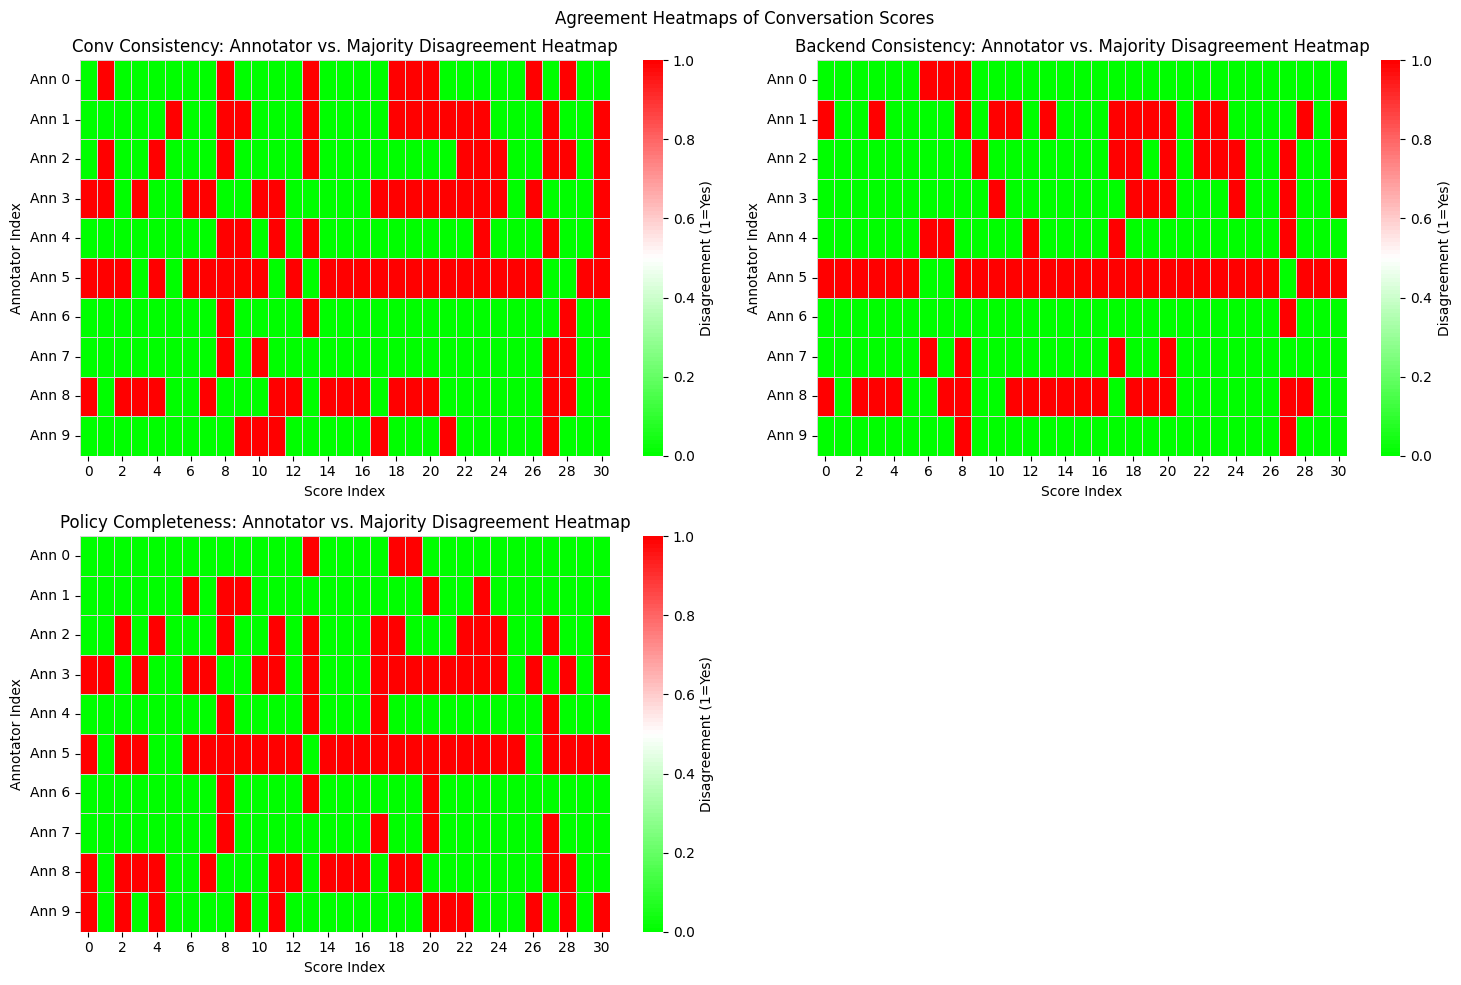

In [503]:
def generate_disagreement_matrix(scores: dict):
	plt.figure(figsize=(15, 10))
	plt.suptitle('Agreement Heatmaps of Conversation Scores')
	dims = ['conv_consistency', 'backend_consistency', 'policy_completeness']

	# Define the colormap
	colors = [(0, 1, 0), (1, 1, 1), (1, 0, 0)]  # Green -> White -> Red
	n_bins = 100  # Discretize the interpolation into bins
	cmap_name = 'green_red'
	cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
	for i, metric in enumerate(dims, 1):
		annotator_matrix = np.concat(
			(scores["turn"][metric], scores["dial"][metric]),
			axis=1
		).astype(dtype=np.int64)
		# Compute the column‐wise majority vote
		maj = np.apply_along_axis(
			lambda col: np.bincount(col).argmax(), axis=0, 
			arr=annotator_matrix
		)
		# Build a disagreement mask (0 = agree, 1 = disagree)
		disagree = (annotator_matrix != maj).astype(int)
		plt.subplot(2, 2, i)
		ax = sns.heatmap(
			disagree,
			cmap=cm,
			cbar_kws={"label": "Disagreement (1=Yes)"},
			linewidths=0.5,
			linecolor="lightgray",
			square=False
		)
		ax.set_xlabel("Score Index")
		ax.set_ylabel("Annotator Index")
		ax.set_yticklabels(
			[f"Ann {i}" for i in range(annotator_matrix.shape[0])], 
			rotation=0
		)
		metric_title = metric.replace('_', ' ').title()
		ax.set_title(f"{metric_title}: Annotator vs. Majority Disagreement Heatmap")
	plt.tight_layout()
	plt.show()

generate_disagreement_matrix(eval_scores)

### Prune Score Matrix of Bad Annotators 

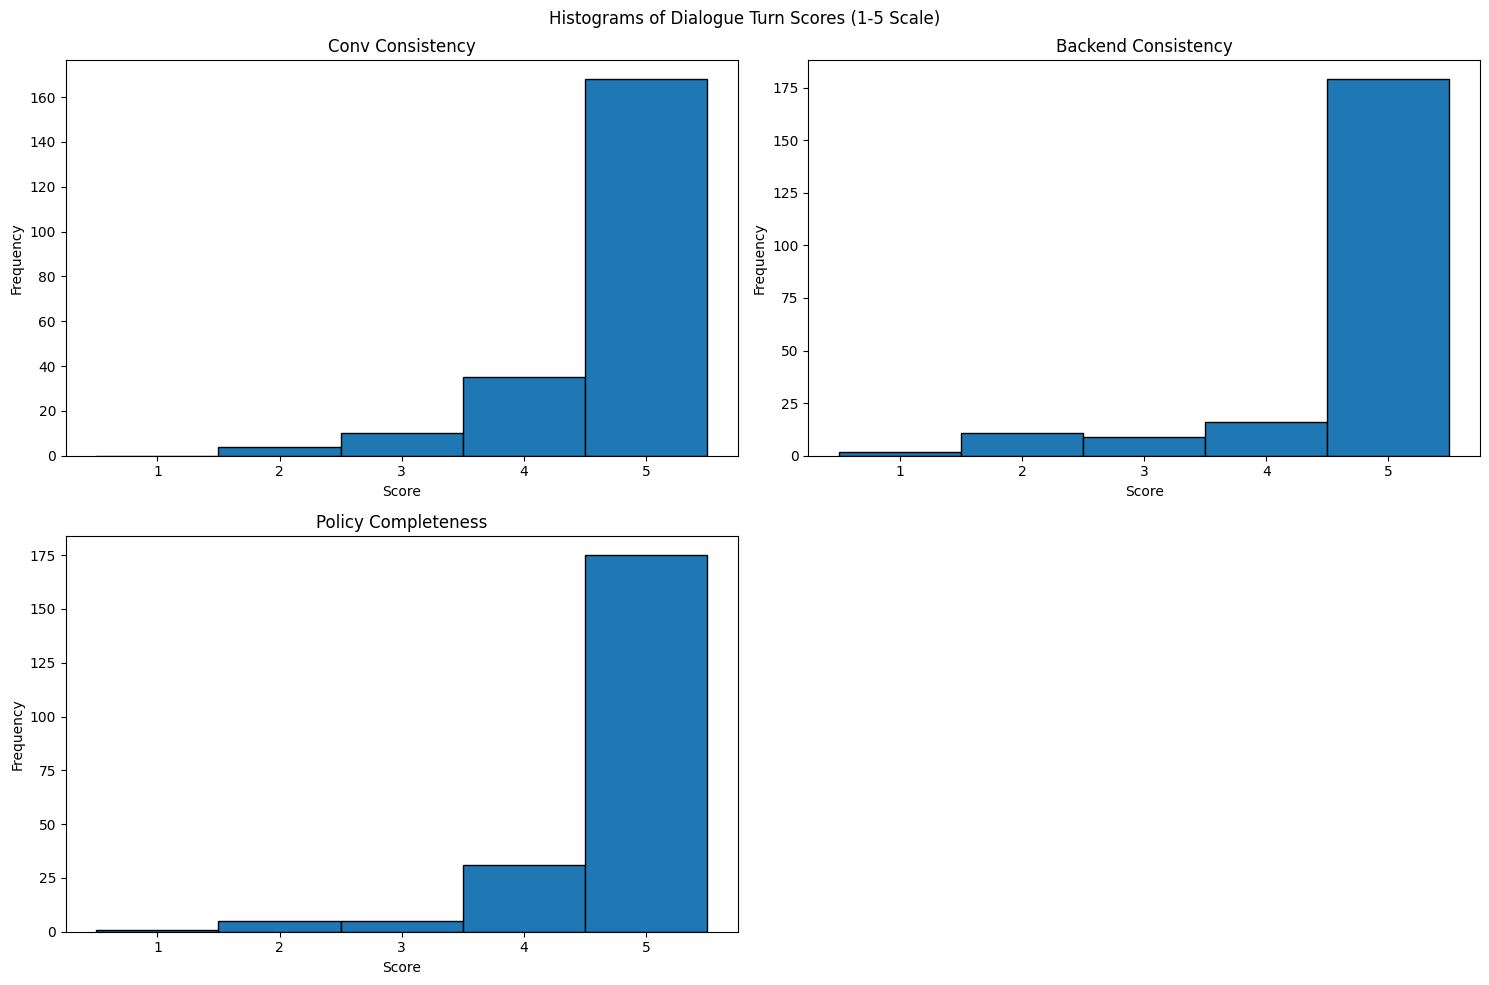

In [504]:
def generate_histograms(scores: dict, drop_annotators: list):#, output_dir):
	# Histogram for 1-10 scale metrics
	plt.figure(figsize=(15, 10))
	plt.suptitle('Histograms of Dialogue Turn Scores (1-5 Scale)')
    
	dims = ['conv_consistency', 'backend_consistency', 'policy_completeness']
	for i, metric in enumerate(dims, 1):
		# compile score matrix and prune bad annotators
		annotator_matrix = np.concat(
			(scores["turn"][metric], scores["dial"][metric]),
			axis=1
		).astype(dtype=np.int64)
		pruned_matrix = np.delete(annotator_matrix, drop_annotators, axis=0)
		# flatten score matrix and create histogram 
		all_scores = pruned_matrix.flatten()
		plt.subplot(2, 2, i)
		plt.hist(all_scores, bins=np.arange(0.5, 6.5, 1), edgecolor='black')
		plt.title(metric.replace('_', ' ').title())
		plt.xticks(np.arange(1, 6, 1))
		plt.xlabel('Score')
		plt.ylabel('Frequency')

	plt.tight_layout()
	plt.show()
	# plt.savefig(os.path.join(output_dir, 'score_histograms_1_5.png')) 

drop_annotators = [3, 5, 8] # [1, 2, 3, 5, 8]
pruned_new_annotators = num_annotators - len(drop_annotators)
generate_histograms(eval_scores, drop_annotators)


In [505]:

def calculate_percent_agreement(scores: dict, drop_annotators: list) -> dict:
	dims = ['conv_consistency', 'backend_consistency', 'policy_completeness']
	percent_agreement = {}
	for metric in dims:
		annotator_matrix = np.concat(
			(scores["turn"][metric], scores["dial"][metric]),
			axis=1
		).astype(dtype=np.int64)
		pruned_matrix = np.delete(annotator_matrix, drop_annotators, axis=0)
		agree_array = np.all(pruned_matrix==pruned_matrix[0:1, :], axis=0)
		percent_agreement[metric] = float(agree_array.mean())
	return percent_agreement

p_agree = calculate_percent_agreement(eval_scores, drop_annotators)
pprint.pprint(p_agree, compact=True)

{'backend_consistency': 0.3548387096774194,
 'conv_consistency': 0.3548387096774194,
 'policy_completeness': 0.3548387096774194}


### Calculate IRR

In [506]:
def calculate_krippendorff_alpha(data: np.ndarray) -> float:
	"""Calculate Krippendorff's alpha for ordinal data"""
	try:
		return alpha(
			reliability_data=data.astype(np.int64), 
			value_domain=[1,2,3,4,5], 
			level_of_measurement='interval'
		)
	except Exception as e:
			print(f"Krippendorff calculation error: {e}")
			return None

def calculate_kappa(data: np.ndarray, n_cat: int) -> dict:
	"""Calculate kappa statistic for more than 2 raters (fleiss and randolph)"""
	try:
		data_table, _ = aggregate_raters(data=data, n_cat=n_cat)
		# randolph method gives best performance
		fleiss = fleiss_kappa(table=data_table, method='fleiss') 
		randolph = fleiss_kappa(table=data_table, method='randolph') 
		return {"fleiss": fleiss, "randolph": randolph}
	except Exception as e:
		print(f"Fleiss calculation error: {e}")
		return None

def calculate_cohen_kappa(data: np.ndarray, n_cat: int) -> float:
	"""Calculate Cohen's kappa for 2 raters"""
	try:
		data_table, _ = to_table(data=data, bins=n_cat)
		return cohens_kappa(table=data_table, wt='linear')['kappa']
	except Exception as e:
		print(f"Cohen calculation error: {e}")
		return None
	
def calculate_gwet_ac(data: np.ndarray) -> float:
	"""Calculate Gwet's AC1 for data with skew in distribution"""
	cac_raters = CAC(pd.DataFrame(data))
	gwet = cac_raters.gwet()
	# pprint.pprint(gwet, compact=True)
	return float(gwet['est']['coefficient_value'])

def calculate_irr(
	num_annotators: int, 
	scores: dict, 
	drop_annotators: list,
	debug: bool):
	"""Calculate agreement metrics between annotators and between annotators and LLM"""
	metrics = {}    
	# calculate irr scores
	dims = ['conv_consistency', 'backend_consistency', 'policy_completeness']
	for metric in dims:
		# compile matrix and prune annotators
		annotator_matrix = np.concat(
			(scores["turn"][metric], scores["dial"][metric]),
			axis=1
		).astype(dtype=np.int64)
		pruned_matrix = np.delete(annotator_matrix, drop_annotators, axis=0)
		# calculate irr scores
		k_alpha = calculate_krippendorff_alpha(pruned_matrix)
		processed_data = pruned_matrix.T.astype(np.int64) - 1
		kappa = calculate_kappa(processed_data, 5)
		f_kappa = kappa['fleiss']
		r_kappa = kappa['randolph']
		gwet_ac = calculate_gwet_ac(pruned_matrix)
		metrics[metric] = {
			'k_alpha': float(k_alpha) if k_alpha is not None else 0.0,
			'f_kappa': float(f_kappa) if f_kappa is not None else 0.0,
			'r_kappa': float(r_kappa) if r_kappa is not None else 0.0,
			'gwet_ac1': float(gwet_ac) if gwet_ac is not None else 0.0
		}
		# debug info
		if debug:
			all_human_scores = []
			for annotator_idx in range(num_annotators):
				scores_array = np.array(pruned_matrix[annotator_idx])
				valid_scores = scores_array[~np.isnan(scores_array)]
				all_human_scores.extend(valid_scores)
				print(f"\nDebug information for {metric}:")
				print(f"Number of valid scores per annotator:")
				for i in range(num_annotators):
					valid_count = np.sum(~np.isnan(pruned_matrix[i]))
					print(f"Annotator {i}: {valid_count}")
				print(f"Total samples with valid scores: {len(all_human_scores)}")
	return metrics

agreement_metrics = calculate_irr(
	pruned_new_annotators, 
	eval_scores, 
	drop_annotators,
	False
)
print("agreement metrics") 
pprint.pprint(agreement_metrics, compact=True)

agreement metrics
{'backend_consistency': {'f_kappa': 0.06273138626079856,
                         'gwet_ac1': 0.69297,
                         'k_alpha': 0.10227072698468564,
                         'r_kappa': 0.6370967741935485},
 'conv_consistency': {'f_kappa': 0.12080575211138991,
                      'gwet_ac1': 0.58158,
                      'k_alpha': 0.2321665476068986,
                      'r_kappa': 0.5910138248847924},
 'policy_completeness': {'f_kappa': 0.07781085512123578,
                         'gwet_ac1': 0.65997,
                         'k_alpha': 0.16885625965996898,
                         'r_kappa': 0.6217357910906296}}


### Calculate Pairwise (Cohen) IRR 

0.17565312789021176
0.11255529204184225
0.145827655411125


/Users/carlguo/miniconda3/envs/turn-eval/lib/python3.11/site-packages/statsmodels/stats/inter_rater.py:504: RuntimeWarning: invalid value encountered in scalar divide
  self['z_value'] = self['kappa'] / self['std_kappa0']
/Users/carlguo/miniconda3/envs/turn-eval/lib/python3.11/site-packages/statsmodels/stats/inter_rater.py:501: RuntimeWarning: invalid value encountered in sqrt
  self['std_kappa'] = np.sqrt(self['var_kappa'])
/Users/carlguo/miniconda3/envs/turn-eval/lib/python3.11/site-packages/statsmodels/stats/inter_rater.py:502: RuntimeWarning: invalid value encountered in sqrt
  self['std_kappa0'] = np.sqrt(self['var_kappa0'])


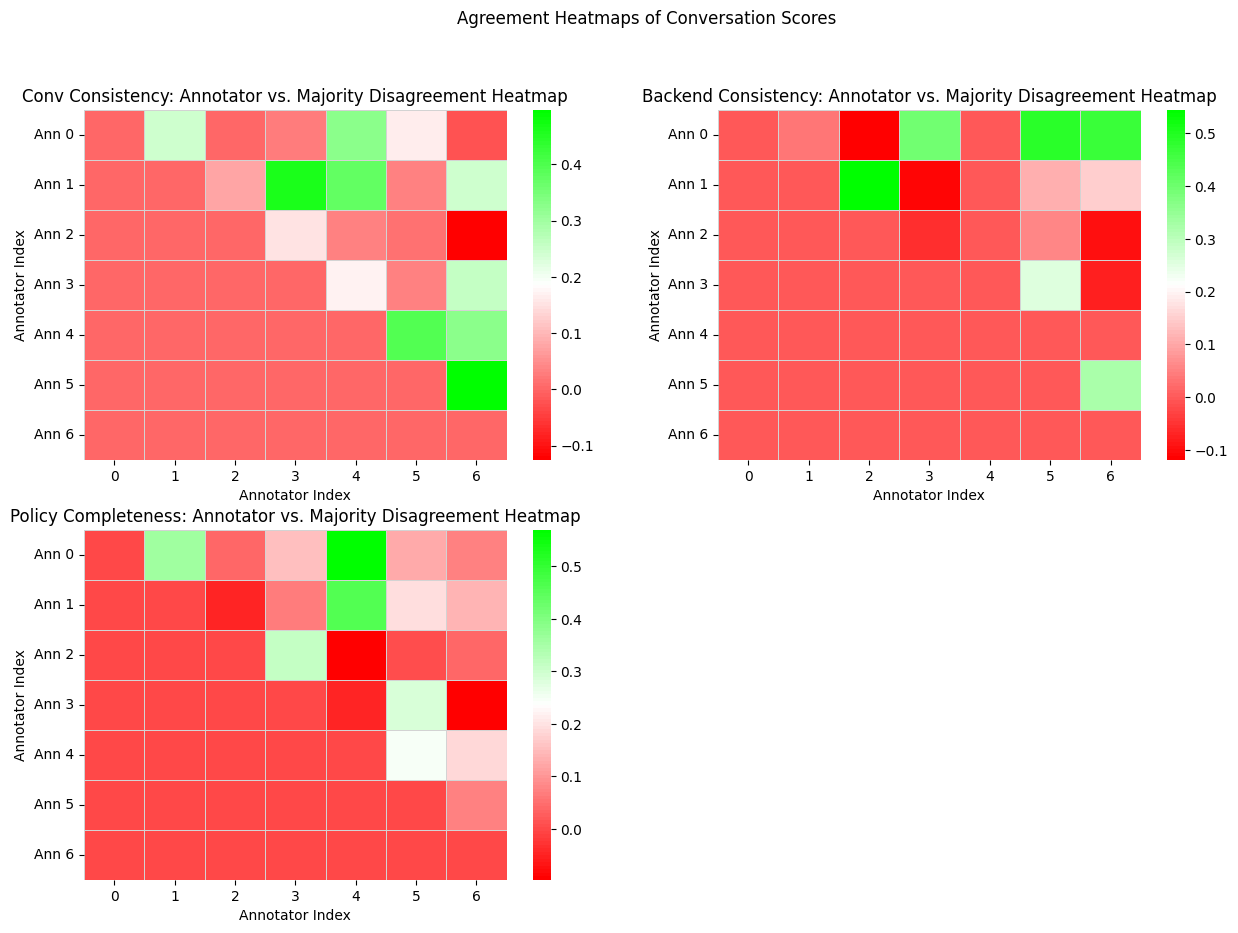

In [507]:
def calculate_pairwise_irr(
	num_annotators: int, 
	scores: dict, 
	drop_annotators: list) -> float:
	"""Get pairwise IRR scores for all annotators, then return average"""
	plt.figure(figsize=(15, 10))
	plt.suptitle('Agreement Heatmaps of Conversation Scores')
	# Define the colormap
	colors = [(1, 0, 0), (1, 1, 1), (0, 1, 0)]  # Green -> White -> Red
	n_bins = 100  # Discretize the interpolation into bins
	cmap_name = 'red_green'
	cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
	# calculate irr scores
	dims = ['conv_consistency', 'backend_consistency', 'policy_completeness']
	for i, metric in enumerate(dims, 1):
		# compile matrix and prune annotators
		annotator_matrix = np.concat(
			(scores["turn"][metric], scores["dial"][metric]),
			axis=1
		).astype(dtype=np.int64)
		pruned_matrix = np.delete(annotator_matrix, drop_annotators, axis=0)
		irr_pairwise = np.zeros(shape=(num_annotators, num_annotators))
		num_calcs = 0
		for a1 in range(0, num_annotators):
			for a2 in range(a1+1, num_annotators):
				pairwise_data = np.array([pruned_matrix[a1], pruned_matrix[a2]]).T - 1
				irr_score = calculate_cohen_kappa(pairwise_data, 5)
				irr_pairwise[a1][a2] = irr_score if not np.isnan(irr_score) else 0
				num_calcs += 1
		avg_irr = irr_pairwise.sum() / num_calcs
		print(avg_irr)
		plt.subplot(2, 2, i)
		ax = sns.heatmap(
			irr_pairwise,
			cmap=cm,
			linewidths=0.5,
			linecolor="lightgray",
			square=False
		)
		ax.set_xlabel("Annotator Index")
		ax.set_ylabel("Annotator Index")
		ax.set_yticklabels(
			[f"Ann {i}" for i in range(pruned_matrix.shape[0])], 
			rotation=0
		)
		metric_title = metric.replace('_', ' ').title()
		ax.set_title(f"{metric_title}: Annotator vs. Majority Disagreement Heatmap")
	plt.show()
	return

calculate_pairwise_irr(	
	pruned_new_annotators, 
	eval_scores, 
	drop_annotators
)

### Write Results to File

In [508]:
# save results
output_dir = 'agreement_scores/' + os.path.basename(human_eval_csv).split('.')[0]
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'human_llm_comparison.json'), 'w') as f:
		json.dump(agreement_metrics, f, indent=4)    
print(f"\nResults saved to {output_dir}")


Results saved to agreement_scores/pilot-eval-irr
